In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io
import html
from datetime import datetime
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, HTML
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras import regularizers



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/MyDrive/DATA/Data"

In [ ]:
data = []
labels = []

# Load dataset
for person_name in os.listdir(data_path):
    person_path = os.path.join(data_path, person_name)
    if os.path.isdir(person_path):
        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                data.append(image)
                labels.append(person_name)

data = np.array(data, dtype='float32')
labels = np.array(labels)

data, labels = shuffle(data, labels)
print(data.shape)
print(labels.shape)

(300, 224, 224, 3)
(300,)


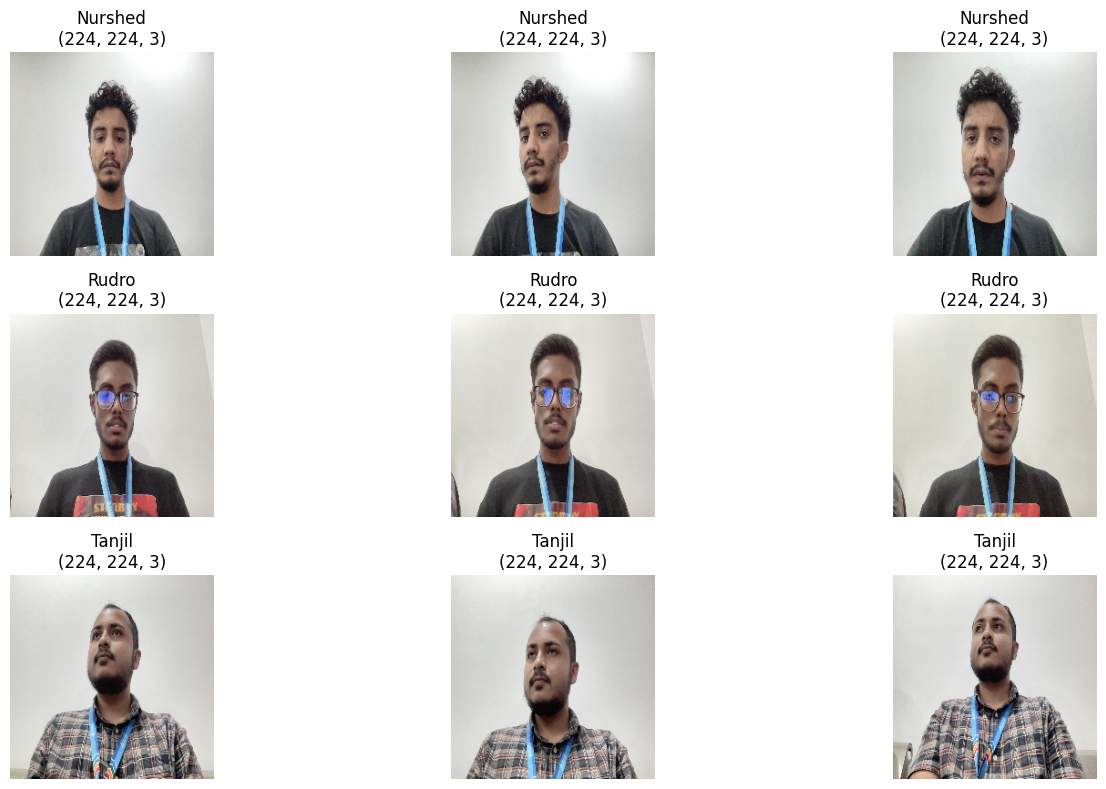

In [ ]:
plt.figure(figsize=(15, 8))
classes = np.unique(labels)

for i, cls in enumerate(classes):
    # Get first 3 images for each class
    class_indices = np.where(labels == cls)[0][:3]

    for j, idx in enumerate(class_indices):
        plt.subplot(len(classes), 3, i*3 + j + 1)
        # Ensure proper display regardless of normalization
        display_img = data[idx]
        if display_img.max() > 1.0:  # If somehow not normalized
            display_img = display_img / 255.0
        plt.imshow(display_img)
        plt.title(f"{cls}\n{display_img.shape}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(240, 224, 224, 3)
(60, 224, 224, 3)
(240,)
(60,)


In [ ]:
le = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train)
Y_test_encoded = le.transform(Y_test)

In [ ]:
model = keras.Sequential([
    layers.Input(shape=X_train.shape[1:]),

    # Block 1
    layers.Conv2D(64, (3,3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3,3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2), strides=(2,2), padding='valid'),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(128, (3,3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3,3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2), strides=(2,2), padding='valid'),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(256, (3,3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, (3,3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, (3,3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2), strides=(2,2), padding='valid'),
    layers.Dropout(0.25),

    # Block 4
    layers.Conv2D(512, (3,3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(512, (3,3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(512, (3,3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2), strides=(2,2), padding='valid'),
    layers.Dropout(0.25),

    # Classifier
   layers.Flatten(),
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(10),
    layers.Activation('softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 256)    │             

 Total params: 435,514,186 (1.62 GB)

 Trainable params: 435,508,810 (1.62 GB)

 Non-trainable params: 5,376 (21.00 KB)

In [ ]:
history = model.fit(
    X_train,
    Y_train_encoded,
    validation_data=(X_test, Y_test_encoded),
    epochs=15,
    batch_size=16
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.4107 - loss: 229.8802 - val_accuracy: 0.4167 - val_loss: 237761.9375
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 356ms/step - accuracy: 0.8831 - loss: 30.4717 - val_accuracy: 0.6000 - val_loss: 11430.0791
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step - accuracy: 0.9693 - loss: 27.0329 - val_accuracy: 0.4333 - val_loss: 70.5677
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 392ms/step - accuracy: 0.9987 - loss: 24.1262 - val_accuracy: 0.4000 - val_loss: 70.9936
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9954 - loss: 23.5583 - val_accuracy: 0.8167 - val_loss: 311.2400
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 359ms/step - accuracy: 0.9820 - loss: 22.4038 - val_accuracy: 0.8500 - val_loss: 60.2919
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 373ms/step - accuracy: 0.9918 - loss: 20.9635 - val_accuracy: 1.0000 - val_loss: 19.8758
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - accuracy: 1.0000 - loss:

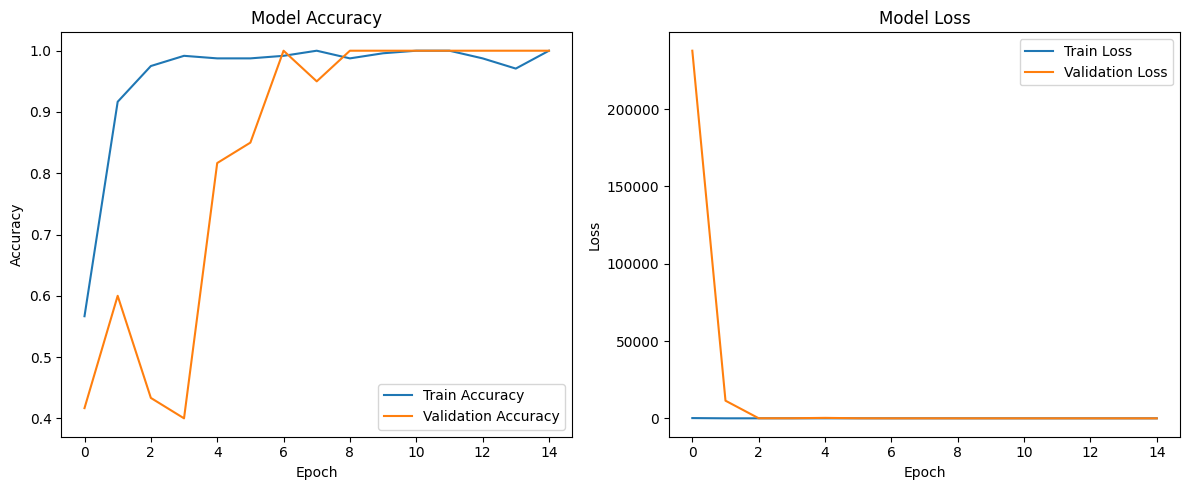


Test Accuracy: 1.0000
Test Loss: 12.8043
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 996ms/step

Classification Report:
              precision    recall  f1-score   support

     Nurshed       1.00      1.00      1.00        17
       Rudro       1.00      1.00      1.00        18
      Tanjil       1.00      1.00      1.00        25

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



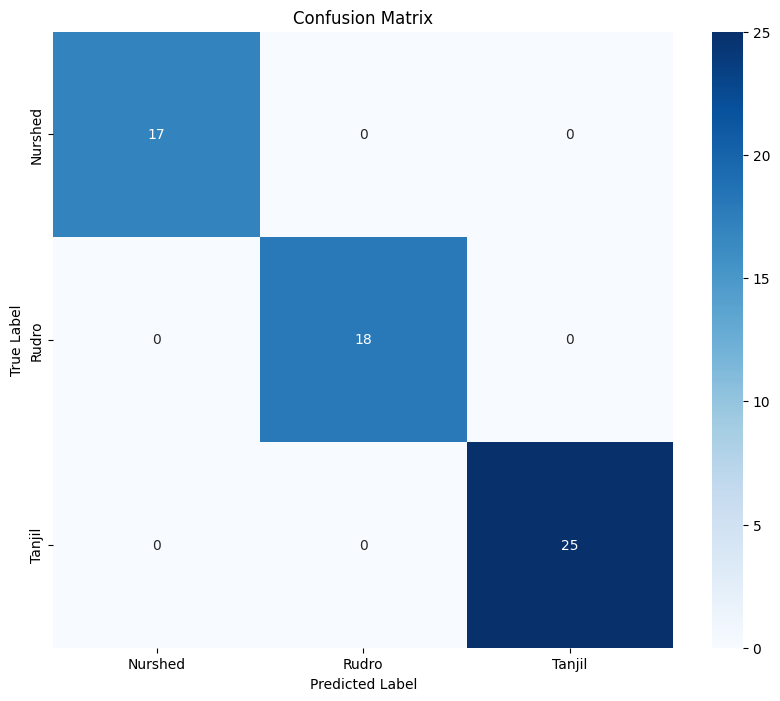

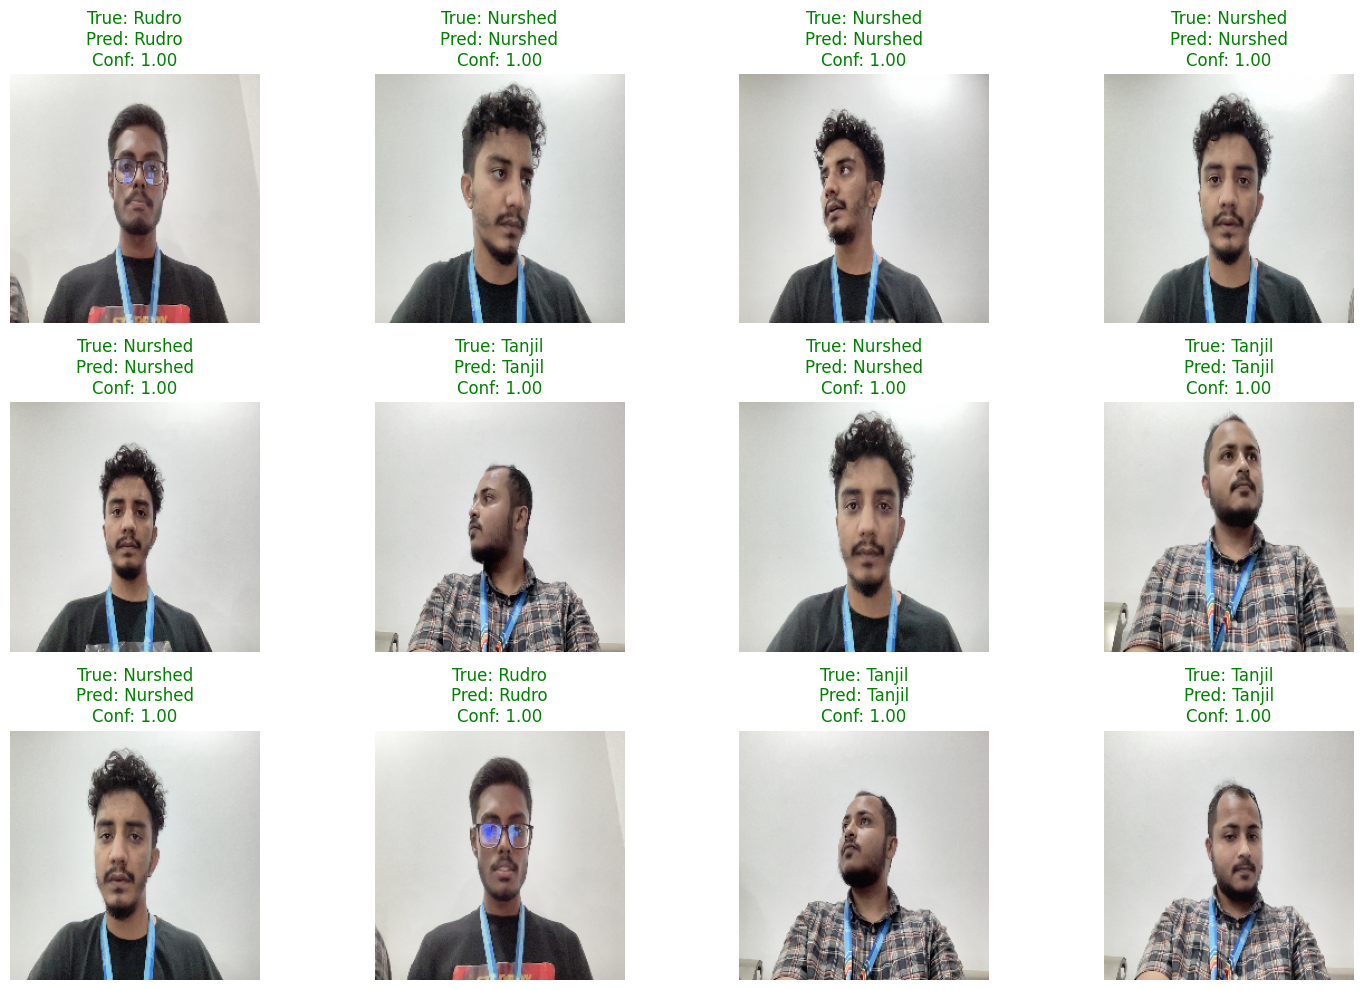

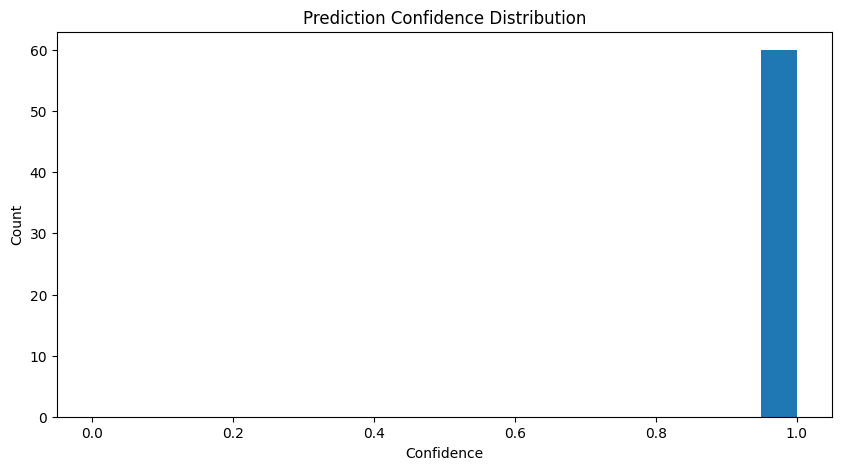


Average confidence: 1.0000
Minimum confidence: 1.0000
Percentage with confidence >0.9: 100.00%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel( 'Epoch')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# 2. Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, Y_test_encoded, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 3. Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# The true labels are already encoded as integers in Y_test_encoded
y_true = Y_test_encoded

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# 4. Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 5. Visualize sample predictions with images
plt.figure(figsize=(15, 10))
for i in range(12):  # Show 12 samples
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test[i].astype('uint8'))

    # true_label and pred_label now correctly use y_true and y_pred_classes
    true_label = le.inverse_transform([y_true[i]])[0]
    pred_label = le.inverse_transform([y_pred_classes[i]])[0]
    confidence = np.max(y_pred[i])

    color = 'green' if y_true[i] == y_pred_classes[i] else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}",
              color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 6. Check prediction confidence distribution
plt.figure(figsize=(10, 5))
confidences = np.max(y_pred, axis=1)
plt.hist(confidences, bins=20, range=(0, 1))
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.show()

print(f"\nAverage confidence: {np.mean(confidences):.4f}")
print(f"Minimum confidence: {np.min(confidences):.4f}")
print(f"Percentage with confidence >0.9: {np.mean(confidences > 0.9)*100:.2f}%")

In [ ]:
# Save Model and Label Encoder
from tensorflow.keras.models import save_model


save_model(model, './resources/data/my_vgg.h5')

# Save label encoder
import pickle
with open('./resources/data/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [ ]:
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import time
from datetime import datetime

# ========= LOAD MODEL =========
try:
    tf.keras.backend.clear_session()
    model = load_model('./resources/data/my_vgg.h5')
    with open('./resources/data/label_encoder.pkl', 'rb') as f:
        le = pickle.load(f)
    print(" Model and label encoder loaded")
    print(f"Classes in label encoder: {le.classes_}")  # Debug: Show available classes
    print(f"Model input shape: {model.input_shape}")  # Debug: Show expected input shape
except Exception as e:
    print(f"Failed to load model or label encoder: {e}")
    raise

# Initialize face cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# ========= HTML/JAVASCRIPT SETUP =========
display(HTML('''
<div style="position: relative;">
    <video id="video" width="640" height="480" autoplay playsinline style="display:none;"></video>
    <canvas id="canvas" width="640" height="480" style="display:none;"></canvas>
    <img id="output" style="max-width:800px; border:2px solid #333;"/>
    <div style="margin-top:10px;">
        <button id="stopBtn" style="padding:8px 15px;background:#ff4444;color:white;border:none;border-radius:4px;">
            Stop Camera
        </button>
        <span id="status" style="margin-left:15px;color:#555;">Status: Initializing...</span>
    </div>
    <div id="debugInfo" style="margin-top:10px; font-family:monospace;"></div>
</div>
'''))

display(Javascript('''
var video = document.getElementById('video');
var canvas = document.getElementById('canvas');
var ctx = canvas.getContext('2d');
var streaming = false;

async function setupCamera() {
    try {
        const stream = await navigator.mediaDevices.getUserMedia({
            video: { width: 640, height: 480, facingMode: "user" },
            audio: false
        });
        video.srcObject = stream;
        await new Promise(resolve => video.onplaying = resolve);
        streaming = true;
        document.getElementById('status').textContent = "Status: Active";
        return true;
    } catch(err) {
        console.error("Camera error:", err);
        document.getElementById('status').textContent = "Status: Error - " + err.name;
        return false;
    }
}

function captureFrame() {
    if (!streaming) return null;
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    ctx.drawImage(video, 0, 0, canvas.width, canvas.height);
    return canvas.toDataURL('image/jpeg', 0.8);
}

function updateImage(dataUrl) {
    document.getElementById('output').src = dataUrl;
}

function updateDebugInfo(text) {
    document.getElementById('debugInfo').innerHTML = text;
}

function stopCamera() {
    if (video.srcObject) {
        video.srcObject.getTracks().forEach(track => track.stop());
        streaming = false;
        document.getElementById('status').textContent = "Status: Stopped";
    }
}

document.getElementById('stopBtn').addEventListener('click', stopCamera);

// Initialize camera
setupCamera();
'''))

# Wait for camera to initialize
time.sleep(2)

# ========= MAIN PROCESSING LOOP =========
print("Starting face detection... Press stop button to end.")

# Confidence threshold adjustment
CONFIDENCE_THRESHOLD = 0.6 # Start with lower threshold

try:
    while True:
        # Get frame from JavaScript
        frame_data = eval_js("captureFrame()")
        if not frame_data:
            time.sleep(0.1)
            continue

        # Convert frame to OpenCV format
        try:
            header, encoded = frame_data.split(",", 1)
            binary = b64decode(encoded)
            img_array = np.frombuffer(binary, dtype=np.uint8)
            frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        except Exception as e:
            print("⚠️ Frame decoding error:", e)
            continue

        if frame is None:
            continue

        # Mirror the frame for more natural viewing
        frame = cv2.flip(frame, 1)

        # Convert to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)

        # Detect faces
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(80, 80),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        debug_text = ""

        for (x, y, w, h) in faces:
            try:
                # Extract face region
                face = frame[y:y+h, x:x+w]

                # Verify face extraction
                if face.size == 0:
                    debug_text += "⚠️ Empty face region detected<br>"
                    continue

                # Preprocess exactly as done during training
                face_input = cv2.resize(face, (224, 224))  # Match model input size
                face_input = face_input.astype('float32') / 255.0  # Normalize

                # Check if model expects batch dimension
                if len(model.input_shape) == 4:
                    face_input = np.expand_dims(face_input, axis=0)

                # Make prediction
                pred = model.predict(face_input, verbose=0)[0]
                confidence = np.max(pred)
                predicted_class = np.argmax(pred)

                debug_text += f"Face detected at ({x},{y})<br>"
                debug_text += f"Raw prediction: {pred}<br>"
                debug_text += f"Max confidence: {confidence:.4f}<br>"
                debug_text += f"Predicted class: {predicted_class}<br>"

                if confidence > CONFIDENCE_THRESHOLD:
                    try:
                        name = le.inverse_transform([predicted_class])[0]
                        color = (0, 255, 0)  # Green
                        label = f"{name} - {datetime.now().strftime('%H:%M:%S %d-%m-%Y')}"
                        status = " Authorized"
                    except Exception as e:
                        debug_text += f"Label inverse transform failed: {str(e)}<br>"
                        color = (0, 0, 255)  # Red
                        label = "Unauthorized"
                        status = "Label Error"
                else:
                    color = (0, 0, 255)  # Red
                    label = "Unauthorized"
                    status = " Low Confidence"

                debug_text += f"Status: {status} (Threshold: {CONFIDENCE_THRESHOLD})<br>"

                # Update debug info
                eval_js(f"updateDebugInfo(`{debug_text}`)")

                # Draw rectangle around face
                cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

                # Draw label background
                cv2.rectangle(frame, (x, y-30), (x+w, y), color, -1)

                # Put text label
                cv2.putText(frame, label, (x+5, y-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            except Exception as e:
                debug_text += f"Face processing error: {str(e)}<br>"
                eval_js(f"updateDebugInfo(`{debug_text}`)")

        # Encode frame back to JPEG
        _, jpeg = cv2.imencode('.jpg', frame)
        b64_img = b64encode(jpeg).decode()

        # Update the displayed image
        eval_js(f"updateImage('data:image/jpeg;base64,{b64_img}')")

        # Small delay to prevent high CPU usage
        time.sleep(0.1)

except Exception as e:
    print(f"Error: {e}")
finally:
    # Clean up
    eval_js("stopCamera()")
    print("Camera stopped")

 Model and label encoder loaded
Classes in label encoder: ['Nurshed' 'Rudro' 'Tanjil']
Model input shape: (None, 224, 224, 3)


<IPython.core.display.Javascript object>

Starting face detection... Press stop button to end.
Camera stopped


KeyboardInterrupt: 